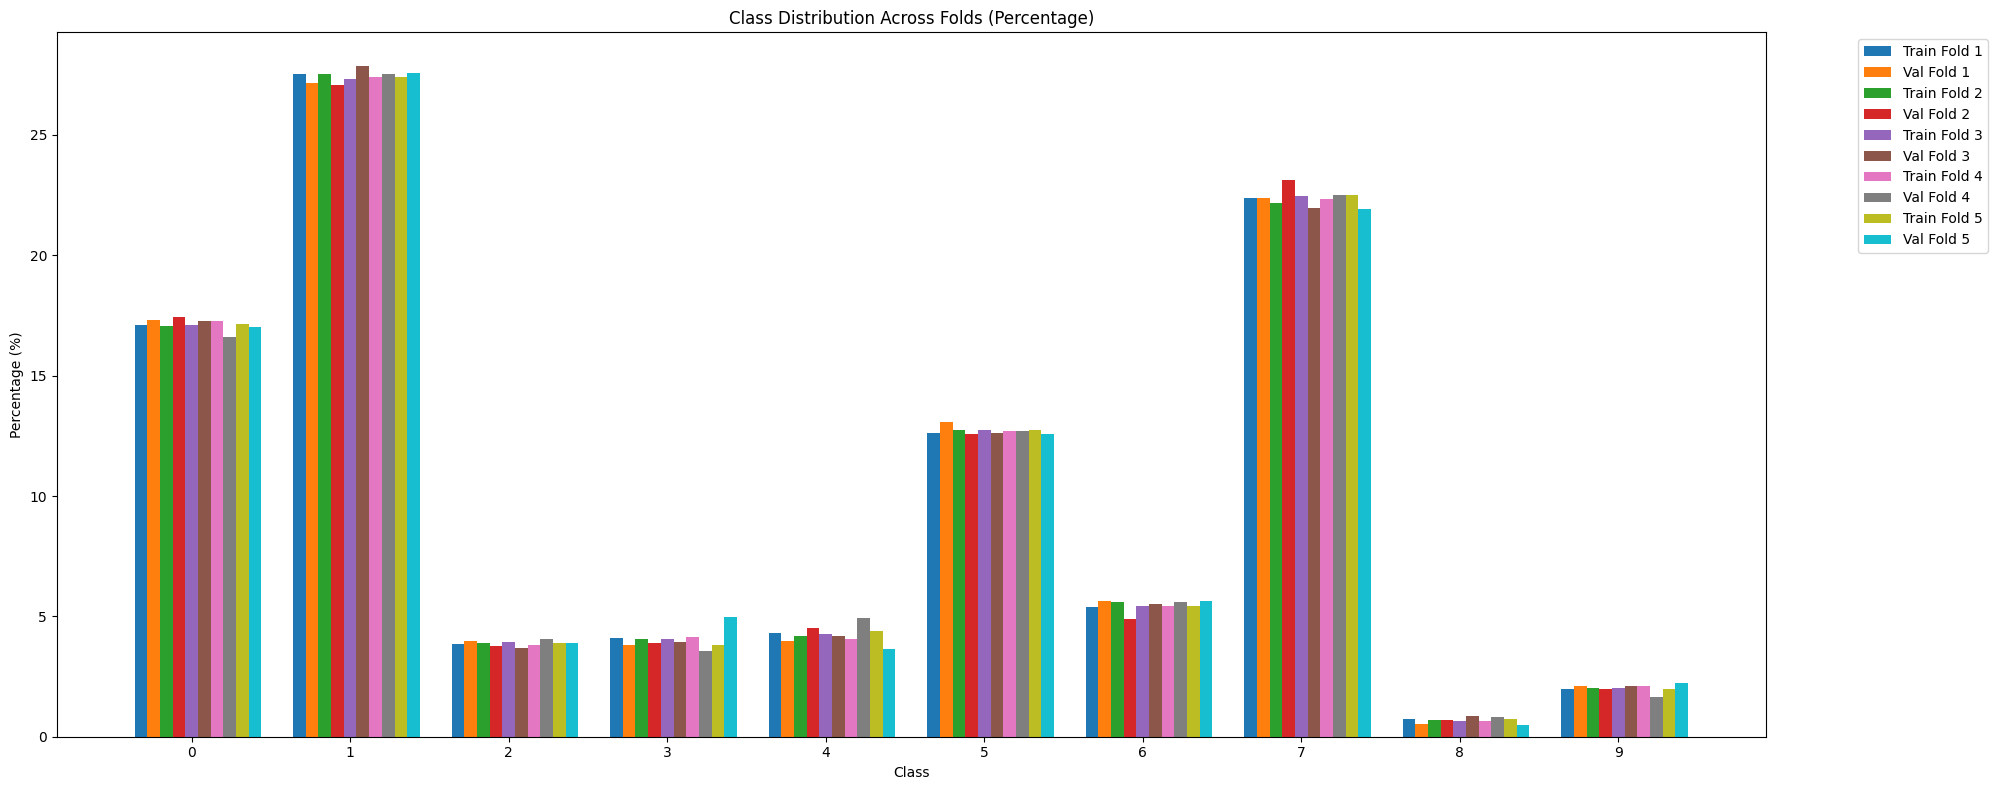

In [9]:
# YOLO DataSet 기준

import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 경로 설정
image_folder = '/data/ephemeral/home/MCG/yolo_dataset/combined'
label_folder = '/data/ephemeral/home/MCG/yolo_dataset/combined'

# 이미지와 라벨 매칭
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
# 숫자 순으로 파일명 정렬
image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))  # 파일명에서 숫자 부분만 추출하여 정렬
label_files = [f.replace('.jpg', '.txt') for f in image_files]

# X, y, groups 구성
X = image_files  # 이미지 파일 리스트가 X 역할
y = []  # 각 이미지에 대한 대표 클래스 ID 저장

# 라벨 파일에서 가장 빈번하게 등장하는 클래스 정보 추출
for label_file in label_files:
    label_path = os.path.join(label_folder, label_file)
    with open(label_path, 'r') as f:
        labels = f.readlines()
        # 각 라벨 파일에서 가장 많이 등장한 class_id 선택
        class_ids = [int(label.split()[0]) for label in labels]
        most_common_class = max(set(class_ids), key=class_ids.count)  # 가장 많이 등장한 클래스 선택
        y.append(most_common_class)

# StratifiedKFold 객체 생성
n_splits = 5  # 원하는 K 값
sgkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=156561)

# 각 Fold의 클래스 비율 저장용 리스트
train_percentages_per_fold = []
val_percentages_per_fold = []

# K-Fold 분할 및 클래스 비율 계산
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y)):
    train_images = [X[i] for i in train_idx]
    val_images = [X[i] for i in val_idx]
    
    # Train, Validation 데이터에 대해 각 이미지의 모든 클래스 라벨을 가져옴
    train_labels_all = []
    val_labels_all = []

    for train_image in train_images:
        label_file = train_image.replace('.jpg', '.txt')
        label_path = os.path.join(label_folder, label_file)
        with open(label_path, 'r') as f:
            labels = f.readlines()
            for label in labels:
                train_labels_all.append(int(label.split()[0]))  # 모든 클래스 라벨을 가져옴

    for val_image in val_images:
        label_file = val_image.replace('.jpg', '.txt')
        label_path = os.path.join(label_folder, label_file)
        with open(label_path, 'r') as f:
            labels = f.readlines()
            for label in labels:
                val_labels_all.append(int(label.split()[0]))  # 모든 클래스 라벨을 가져옴
    
    # 클래스 분포 계산
    train_counter = Counter(train_labels_all)
    val_counter = Counter(val_labels_all)
    
    # 클래스 레이블 목록
    labels = sorted(train_counter.keys())
    
    # 백분율 계산
    train_total = len(train_labels_all)
    val_total = len(val_labels_all)
    
    train_percentages = [train_counter[label] / train_total * 100 for label in labels]
    val_percentages = [val_counter[label] / val_total * 100 for label in labels]
    
    # 각 fold의 백분율 저장
    train_percentages_per_fold.append(train_percentages)
    val_percentages_per_fold.append(val_percentages)

# 그래프 그리기
bar_width = 0.08  # 막대 너비 설정 (좀 더 좁게)
index = np.arange(len(labels))  # 클래스 레이블의 인덱스

plt.figure(figsize=(20, 8))

# 각 Fold에 대해 막대그래프를 그립니다.
for fold in range(n_splits):
    # Train에 해당하는 막대
    plt.bar(index + bar_width * (2 * fold), train_percentages_per_fold[fold], bar_width, label=f'Train Fold {fold + 1}')
    # Validation에 해당하는 막대
    plt.bar(index + bar_width * (2 * fold + 1), val_percentages_per_fold[fold], bar_width, label=f'Val Fold {fold + 1}')

# 플롯 설정
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution Across Folds (Percentage)')
plt.xticks(index + bar_width * (n_splits - 1), labels)  # 클래스 레이블을 x축에 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 범례를 그래프 바깥으로
plt.tight_layout()
plt.show()


Total class object counts:
Class 0: 3966 objects
Class 1: 6352 objects
Class 2: 897 objects
Class 3: 936 objects
Class 4: 982 objects
Class 5: 2943 objects
Class 6: 1263 objects
Class 7: 5178 objects
Class 8: 159 objects
Class 9: 468 objects
[   0    1    2 ... 4880 4881 4882] @@@@@@
[   0    3    4 ... 4880 4881 4882] @@@@@@
[   0    1    2 ... 4878 4881 4882] @@@@@@
[   1    2    3 ... 4879 4880 4881] @@@@@@
[   0    1    2 ... 4879 4880 4882] @@@@@@


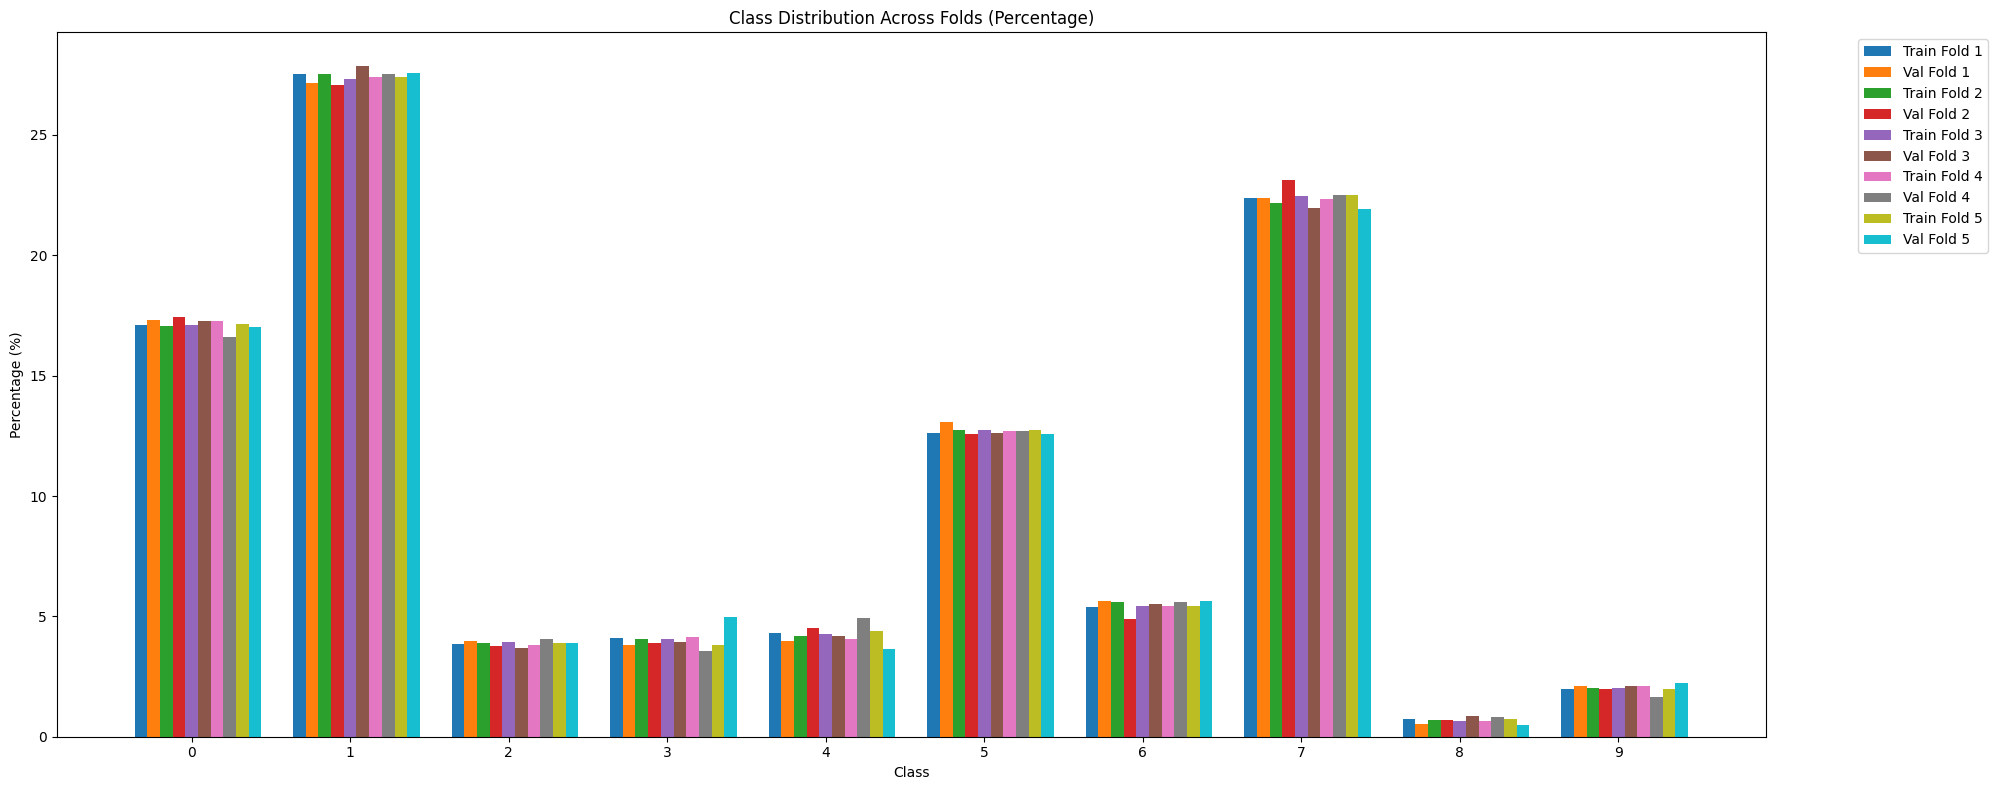

In [10]:
# COCO DataSet 기준

import os
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 경로 설정
image_folder = '/data/ephemeral/home/MCG/dataset/train'
annotation_file = '/data/ephemeral/home/MCG/dataset/train.json'

# COCO json 파일 불러오기
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# 이미지 파일 리스트 및 라벨 정보 구성
X = []  # 이미지 파일 경로
y = []  # 각 이미지에 대한 대표 클래스

# 이미지 ID를 키로 하는 딕셔너리 생성
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

image_id_to_labels = {}  # 이미지 ID별로 클래스 라벨 리스트를 저장할 딕셔너리
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']  # 어노테이션이 참조하는 이미지 ID
    category_id = annotation['category_id']  # 어노테이션이 참조하는 클래스 ID (카테고리)
    
    # 해당 이미지 ID가 아직 딕셔너리에 없으면, 새로운 리스트를 생성
    if image_id not in image_id_to_labels:
        image_id_to_labels[image_id] = []
    
    # 이미지에 해당하는 클래스 ID를 리스트에 추가
    image_id_to_labels[image_id].append(category_id)
    
# 각 이미지에 대해 가장 많이 등장한 클래스 선택
for image_id, labels in image_id_to_labels.items():
    most_common_class = max(set(labels), key=labels.count)  # 가장 많이 등장한 클래스 선택
    y.append(most_common_class)
    X.append(os.path.join(image_folder, image_id_to_filename[image_id]))  # 이미지 파일 경로 추가


# 전체 클래스별 객체 수 계산
total_class_count = Counter()
# 각 이미지의 클래스 라벨을 모두 확인하여 전체 클래스별 객체 수를 집계
for labels in image_id_to_labels.values():
    total_class_count.update(labels)
    
# 전체 클래스별 객체 수 출력
print("Total class object counts:")
for label, count in sorted(total_class_count.items()):
    print(f"Class {label}: {count} objects")
    

# StratifiedKFold 객체 생성
n_splits = 5  # 원하는 K 값
sgkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=156561)

# 각 Fold의 클래스 비율 저장용 리스트
train_percentages_per_fold = []
val_percentages_per_fold = []

image_id_list = list(image_id_to_labels.keys())  # 미리 인덱스를 계산해 리스트로 유지

# K-Fold 분할 및 클래스 비율 계산
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y)):
    train_images = [X[i] for i in train_idx]
    val_images = [X[i] for i in val_idx]
    print(train_idx,"@@@@@@")
    # Train, Validation 데이터에 대해 각 이미지의 모든 클래스 라벨을 가져옴
    train_labels_all = []
    val_labels_all = []

    for i in train_idx:
        train_labels_all.extend(image_id_to_labels[image_id_list[i]])

    for i in val_idx:
        val_labels_all.extend(image_id_to_labels[image_id_list[i]])

    # 클래스 분포 계산
    train_counter = Counter(train_labels_all)
    val_counter = Counter(val_labels_all)
    
    # Fold에 할당된 이미지 수 계산
    num_train_images = len(train_idx)
    num_val_images = len(val_idx)
    
    # 클래스 레이블 목록
    labels = sorted(train_counter.keys())
    
    # 백분율 계산
    train_total = len(train_labels_all)
    val_total = len(val_labels_all)
    
    train_percentages = [train_counter[label] / train_total * 100 for label in labels]
    val_percentages = [val_counter[label] / val_total * 100 for label in labels]
    
    # 각 fold의 백분율 저장
    train_percentages_per_fold.append(train_percentages)
    val_percentages_per_fold.append(val_percentages)

# 그래프 그리기
bar_width = 0.08  # 막대 너비 설정
index = np.arange(len(labels))  # 클래스 레이블의 인덱스

plt.figure(figsize=(20, 8))

# 각 Fold에 대해 막대그래프를 그립니다.
for fold in range(n_splits):
    # Train에 해당하는 막대
    plt.bar(index + bar_width * (2 * fold), train_percentages_per_fold[fold], bar_width, label=f'Train Fold {fold + 1}')
    # Validation에 해당하는 막대
    plt.bar(index + bar_width * (2 * fold + 1), val_percentages_per_fold[fold], bar_width, label=f'Val Fold {fold + 1}')

# 플롯 설정
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution Across Folds (Percentage)')
plt.xticks(index + bar_width * (n_splits - 1), labels)  # 클래스 레이블을 x축에 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 범례를 그래프 바깥으로
plt.tight_layout()
plt.show()


In [28]:
import os
import json
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 경로 설정
image_folder = '/data/ephemeral/home/MCG/dataset/train'
annotation_file = '/data/ephemeral/home/MCG/dataset/train.json'

# COCO json 파일 불러오기
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# 이미지 파일 리스트 및 라벨 정보 구성
X = []  # 이미지 파일 경로
y = []  # 각 이미지에 대한 대표 클래스

# 이미지 ID를 키로 하는 딕셔너리 생성
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# 각 이미지에 대해 가장 빈번한 클래스 추출
image_id_to_labels = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    if image_id not in image_id_to_labels:
        image_id_to_labels[image_id] = []
    image_id_to_labels[image_id].append(category_id)

# 각 이미지에 대해 가장 많이 등장한 클래스 선택
for image_id, labels in image_id_to_labels.items():
    most_common_class = max(set(labels), key=labels.count)  # 가장 많이 등장한 클래스 선택
    y.append(most_common_class)
    X.append(os.path.join(image_folder, image_id_to_filename[image_id]))  # 이미지 파일 경로 추가

# 분산 계산 함수
def calculate_variance(groups_class_distribution):
    """각 클래스별로 분포된 퍼센티지의 분산을 계산"""
    return sum(np.var(groups_class_distribution, axis=0))

# 최적의 random_state와 최소 분산 저장
best_random_state = 47060
min_variance = 5.58852383583772e-05

# 기록할 분산 값 리스트
#variance_log = []

# random_state를 7500부터 30000까지 변경하며 최적의 값을 찾음
image_id_list = list(image_id_to_labels.keys())  # 미리 인덱스를 계산해 리스트로 유지
for random_state in range(50000, 300000):
    sgkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    groups_class_distribution = []  # 10개의 Group의 클래스 분포 저장용 리스트

    # 각 Fold에 대해 클래스 분포 계산
    for train_idx, val_idx in sgkf.split(X, y):
        train_labels_all = []
        val_labels_all = []

        for i in train_idx:
            train_labels_all.extend(image_id_to_labels[image_id_list[i]])

        for i in val_idx:
            val_labels_all.extend(image_id_to_labels[image_id_list[i]])

        # 클래스 분포 계산
        train_counter = Counter(train_labels_all)
        val_counter = Counter(val_labels_all)

        all_classes = sorted(set(train_counter.keys()).union(set(val_counter.keys())))

        train_total = len(train_labels_all)
        val_total = len(val_labels_all)
        
        train_distribution = np.array([train_counter[cls] / train_total if train_total > 0 else 0 for cls in all_classes])
        val_distribution = np.array([val_counter[cls] / val_total if val_total > 0 else 0 for cls in all_classes])
        
        # 각 fold의 학습 및 검증 분포를 추가
        groups_class_distribution.append(train_distribution)
        groups_class_distribution.append(val_distribution)

    # 10개 그룹의 클래스 분포에 대한 분산 계산
    total_variance = calculate_variance(groups_class_distribution)

    # 현재 random_state와 분산 값을 기록
    #variance_log.append(f'random_state: {random_state}, variance: {total_variance}\n')

    # 분산이 최소인 random_state 업데이트
    if total_variance < min_variance:
        min_variance = total_variance
        best_random_state = random_state
        print(f'최적의 random_state: {best_random_state}, 최소 분산: {min_variance}')


print(f'최적의 random_state: {best_random_state}, 최소 분산: {min_variance}')


최적의 random_state: 156561, 최소 분산: 5.3577046382918786e-05


KeyboardInterrupt: 